In [2]:
# housing_regression.py
# A complete linear regression for the housing dataset

In [3]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# 2. Load the dataset
df = pd.read_csv('housing.csv')

In [5]:
# 3. Initial inspection & cleaning
print("=== First five rows ===")
print(df.head(), "\n")

print("=== Data summary (numeric columns) ===")
print(df.describe().T, "\n")

print("=== Missing values per column ===")
print(df.isnull().sum(), "\n")

=== First five rows ===
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

=== Data summary (numeric columns) ===
          

/var/folders/nk/ll9_xqj958jb6d031j0rwjvw0000gn/T/ipykernel_3064/378498453.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


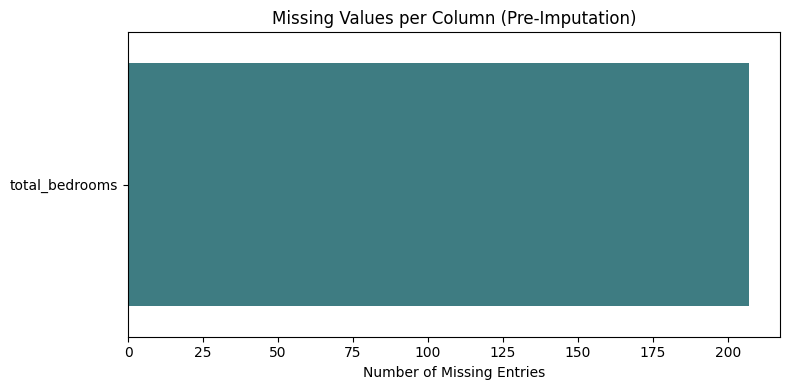

In [6]:
# Figure 1 – Barplot of missing values before imputation
# ------------------------------------------------------
# Run this *before* the median fill step.

import matplotlib.pyplot as plt
import seaborn as sns

# Count NaNs column-wise
na_counts = df.isnull().sum()
na_counts = na_counts[na_counts > 0].sort_values() 

plt.figure(figsize=(8, 4))
sns.barplot(
    x=na_counts.values,
    y=na_counts.index,
    palette="crest",
    orient="h"
)
plt.title("Missing Values per Column (Pre-Imputation)")
plt.xlabel("Number of Missing Entries")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [7]:
# 3.1 Categorical encoding – one‑hot for ocean_proximity (required for OLS)
if "ocean_proximity" in df.columns:
    df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)
else:
    print("Note: 'ocean_proximity' already one‑hot encoded – skipping get_dummies.")

missing_total = df.isnull().sum().sum()
if missing_total > 0:
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    print(f"Imputed {missing_total} missing numeric values with column medians.")
else:
    print("No missing numeric values to impute.")

Imputed 207 missing numeric values with column medians.


In [8]:
# 4. Exploratory Data Analysis (EDA) ───────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns


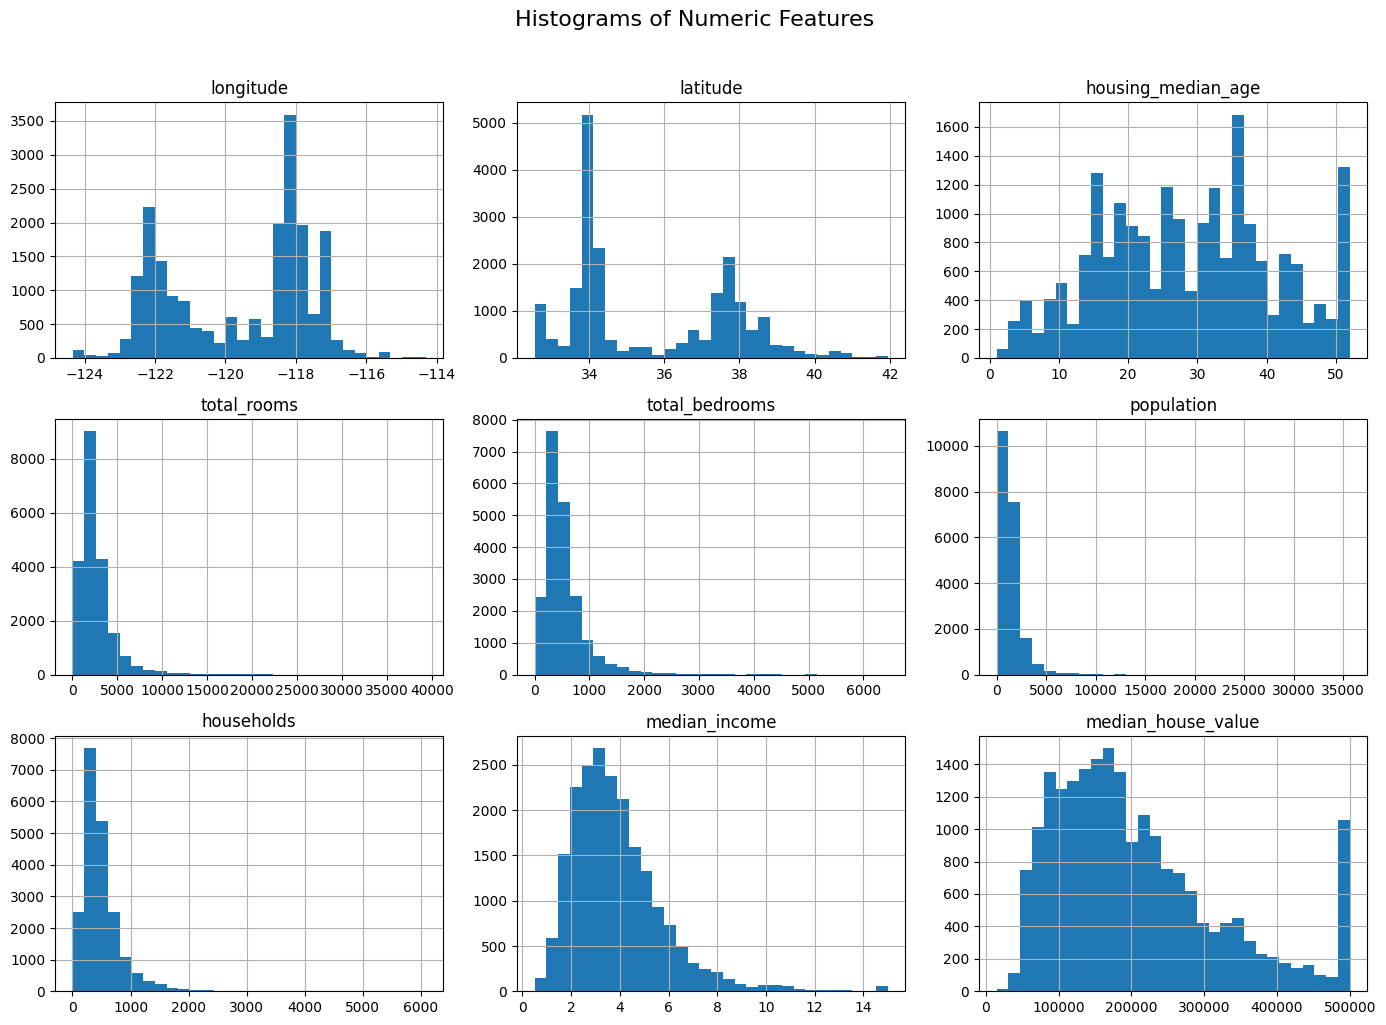

In [9]:
# 4.1 Histograms
_ = df[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Histograms of Numeric Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

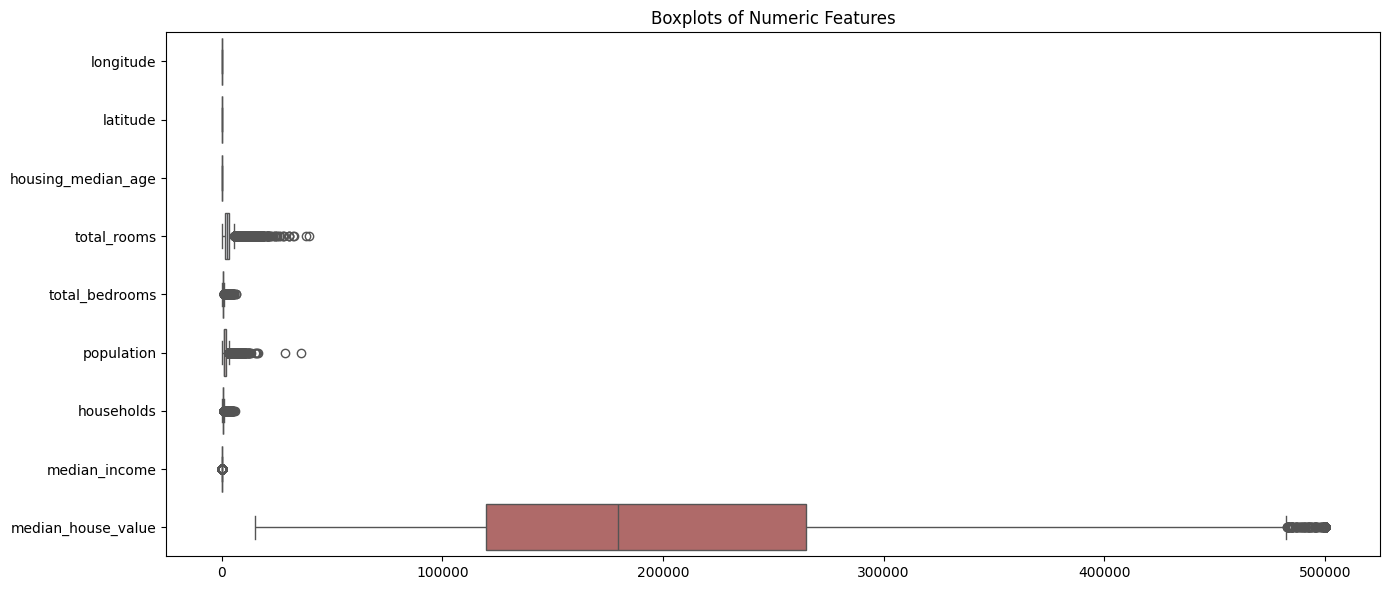

In [10]:
# 4.2 Boxplots
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols], orient="h", palette="vlag")
plt.title("Boxplots of Numeric Features")
plt.tight_layout()
plt.show()

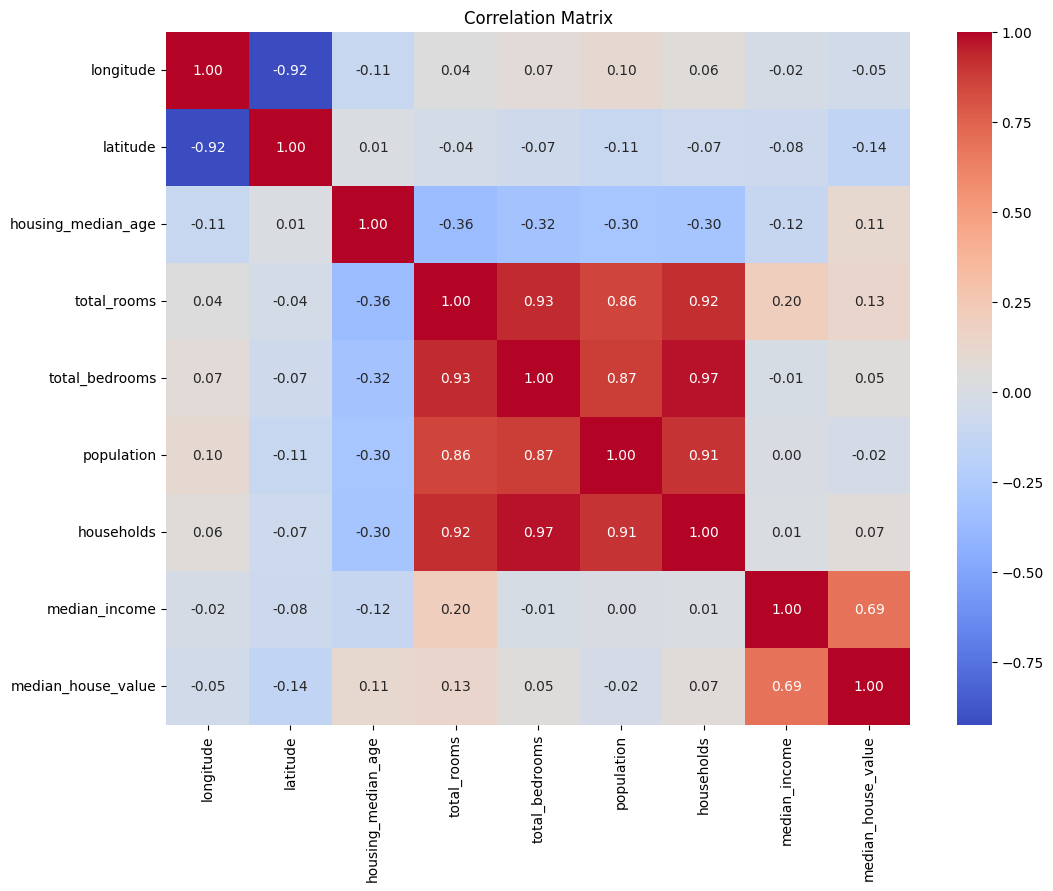

In [11]:
# 4.3 Correlation heatmap
plt.figure(figsize=(12, 9))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
# 5. Outlier detection (report only, no removal) ───────────────────────────
Z = np.abs(stats.zscore(df[numeric_cols]))
outlier_mask = (Z >= 3).any(axis=1)
print(f"Rows with |Z| ≥ 3: {outlier_mask.sum()} (reported, not removed)\n")

Rows with |Z| ≥ 3: 894 (reported, not removed)



In [13]:
# 6. Train‑test split ──────────────────────────────────────────────────────
TARGET = "median_house_value"
X = df.drop(TARGET, axis=1)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [24]:
#regression equation 

coef_series = pd.Series(linreg.coef_, index=X.columns)
eqn = "median_house_value = " + " + ".join(
    f"{b:.4f}*{c}" for c, b in coef_series.items()
) + f" + {linreg.intercept_:.4f}"
print("\nRegression equation:\n", eqn)



Regression equation:
 median_house_value = -26838.2734*longitude + -25468.3520*latitude + 1102.1851*housing_median_age + -6.0215*total_rooms + 102.7894*total_bedrooms + -38.1729*population + 48.2528*households + 39473.9752*median_income + -39786.6562*ocean_proximity_INLAND + 136125.0726*ocean_proximity_ISLAND + -5136.6422*ocean_proximity_NEAR BAY + 3431.1401*ocean_proximity_NEAR OCEAN + -2275547.3817


In [15]:
# 7.1 scikit‑learn fit
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# 7.2 statsmodels OLS for detailed stats
X_train_sm = sm.add_constant(X_train).astype(float)
# Ensure y is float
y_train_float = y_train.astype(float)
ols_model = sm.OLS(y_train_float, X_train_sm).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2550.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:19:13   Log-Likelihood:            -2.0727e+05
No. Observations:               16512   AIC:                         4.146e+05
Df Residuals:                   16499   BIC:                         4.147e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# 8. Diagnostics ───────────────────────────────────────────────────────────
# 8.1 VIF
vif = pd.DataFrame({
    "feature": X_train_sm.columns,
    "VIF": [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
})
print("\n=== Variance Inflation Factors ===")
print(vif, "\n")

# 8.2 Residual analysis
residuals = y_train_float - ols_model.predict(X_train_sm)

# Histogram
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Residuals vs fitted
plt.scatter(ols_model.predict(X_train_sm), residuals, alpha=0.5)
plt.axhline(0, color="red", ls="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()

# Normality & autocorrelation tests
sh_w, sh_p = stats.shapiro(residuals)
dw = sm.stats.stattools.durbin_watson(residuals)
print(f"Shapiro‑Wilk: W = {sh_w:.3f}, p = {sh_p:.4f}")
print(f"Durbin‑Watson : {dw:.3f}\n")

In [16]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# --- 1.  Make column names safe for patsy (no spaces or punctuation) ---
safe_cols = {c: c.replace(" ", "_").replace(">", "gt") for c in df.columns}
df_ren = df.rename(columns=safe_cols)

# --- 2.  Build formula string ---
TARGET = "median_house_value"
predictors = [c for c in df_ren.columns if c != TARGET]
formula = TARGET + " ~ " + " + ".join(predictors)

# --- 3.  Fit formula-based OLS on *training* rows only (to keep parity) ---
train_idx = X_train.index                    # same rows used earlier
ols_formula = smf.ols(formula, data=df_ren.loc[train_idx]).fit()

# --- 4.  Print summary (optional) ---
print(ols_formula.summary())

# --- 5.  Type-II ANOVA table (matches sample report) ---
anova_tbl = anova_lm(ols_formula, typ=2)
print("\n=== ANOVA Table (Type II) ===\n", anova_tbl)


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2550.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:19:16   Log-Likelihood:            -2.0727e+05
No. Observations:               16512   AIC:                         4.146e+05
Df Residuals:                   16499   BIC:                         4.147e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [17]:
# --- Type-II ANOVA on the training data -----------------------------------
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# 1) Make column names patsy-safe (replace spaces, symbols)
safe_map = {c: c.replace(" ", "_").replace("<", "lt").replace(">", "gt")
            for c in df.columns}
df_safe   = df.rename(columns=safe_map)

# 2) Build formula string:  median_house_value ~ all other columns
TARGET = "median_house_value"
predictors = [c for c in df_safe.columns if c != TARGET]
formula = TARGET + " ~ " + " + ".join(predictors)

# 3) Fit formula OLS **on training rows only**
train_idx   = X_train.index              # reuse earlier split
ols_formula = smf.ols(formula, data=df_safe.loc[train_idx]).fit()

# 4) Type-II sums of squares
anova_tbl = anova_lm(ols_formula, typ=2)   # columns: DF, sum_sq, F, PR(>F)
print("\n=== Type-II ANOVA Table ===\n")
print(anova_tbl.round(2))                  # <-- Table 4 for the report



=== Type-II ANOVA Table ===

                                  sum_sq       df         F  PR(>F)
ocean_proximity_INLAND      1.984222e+12      1.0    423.36    0.00
ocean_proximity_ISLAND      7.394035e+10      1.0     15.78    0.00
ocean_proximity_NEAR_BAY    2.773250e+10      1.0      5.92    0.02
ocean_proximity_NEAR_OCEAN  1.798400e+10      1.0      3.84    0.05
longitude                   2.657725e+12      1.0    567.05    0.00
latitude                    2.460813e+12      1.0    525.04    0.00
housing_median_age          2.410103e+12      1.0    514.22    0.00
total_rooms                 2.164805e+11      1.0     46.19    0.00
total_bedrooms              8.359485e+11      1.0    178.36    0.00
population                  4.838225e+12      1.0   1032.29    0.00
households                  1.555713e+11      1.0     33.19    0.00
median_income               5.190783e+13      1.0  11075.10    0.00
Residual                    7.732906e+13  16499.0       NaN     NaN


/var/folders/nk/ll9_xqj958jb6d031j0rwjvw0000gn/T/ipykernel_3064/1126871815.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_df.sort_values('VIF', ascending=False),


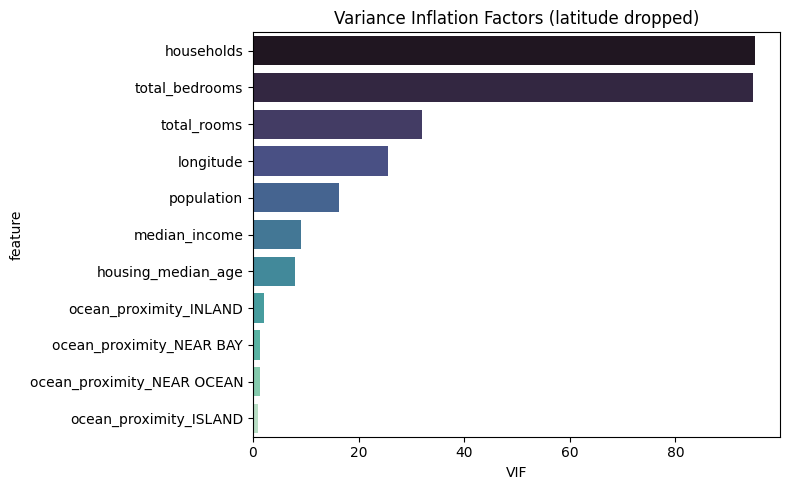

                       feature        VIF
5                   households  95.046604
3               total_bedrooms  94.770052
2                  total_rooms  31.968259
0                    longitude  25.623284
4                   population  16.329079
6                median_income   9.043879
1           housing_median_age   8.034782
7       ocean_proximity_INLAND   2.127360
9     ocean_proximity_NEAR BAY   1.343778
10  ocean_proximity_NEAR OCEAN   1.303188
8       ocean_proximity_ISLAND   1.001616


In [18]:
# ------------------------------------------
#  A)   Drop 'latitude' before VIF analysis
# ------------------------------------------
X_vif = X_train.drop(columns=['latitude'])   # keep longitude as proxy

# Cast to float
X_vif = X_vif.astype(float)

vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=vif_df.sort_values('VIF', ascending=False),
            x='VIF', y='feature', palette='mako')
plt.title('Variance Inflation Factors (latitude dropped)')
plt.tight_layout()
plt.show()

print(vif_df.sort_values('VIF', ascending=False))


In [19]:
# 9. Performance metrics ─────────────────────────────────────────────────--
train_r2 = r2_score(y_train, ols_model.predict(X_train_sm))
test_r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== Model Performance ===")
print(f"R² (train): {train_r2:.4f}")
print(f"R² (test) : {test_r2:.4f}")
print(f"RMSE (test): {rmse:,.2f}\n")

=== Model Performance ===
R² (train): 0.6497
R² (test) : 0.6254
RMSE (test): 70,060.52



In [20]:
#Actual vs Predicted comparison table

compare_df = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Predicted": pd.Series(y_pred)
})
print(compare_df.head(20))


      Actual      Predicted
0    47700.0   54055.448899
1    45800.0  124225.338937
2   500001.0  255489.379492
3   218600.0  268002.431569
4   278000.0  262769.434816
5   158700.0  139606.303956
6   198200.0  290665.423914
7   157500.0  228264.876375
8   340000.0  256506.785610
9   446600.0  407923.858435
10  123200.0  117648.299242
11  253900.0  177556.028014
12  215100.0   49573.548268
13  220500.0  146896.001320
14  219800.0  249178.850823
15  136200.0   51619.432820
16  178400.0  268970.865935
17  187500.0  206538.013935
18  139800.0  237840.978778
19  137500.0  112245.668928


In [22]:
import pandas as pd
from scipy.stats import kurtosis, skew

# numeric_cols already defined earlier
desc = df[numeric_cols].describe().T          # mean, std, etc.

# Add skew and kurtosis
desc['Skew']     = df[numeric_cols].apply(skew, bias=False)
desc['Kurtosis'] = df[numeric_cols].apply(kurtosis, fisher=False, bias=False)
print(desc[['mean', 'std', 'Skew', 'Kurtosis']].round(2))


                         mean        std  Skew  Kurtosis
longitude             -119.57       2.00 -0.30      1.67
latitude                35.63       2.14  0.47      1.88
housing_median_age      28.64      12.59  0.06      2.20
total_rooms           2635.76    2181.62  4.15     35.63
total_bedrooms         536.84     419.39  3.48     25.24
population            1425.48    1132.46  4.94     76.55
households             499.54     382.33  3.41     25.06
median_income            3.87       1.90  1.65      7.95
median_house_value  206855.82  115395.62  0.98      3.33


In [23]:
#Accuracy %

accuracy_pct = compare_df.corr().iloc[0,1] * 100
print(f"Test-set accuracy ≈ {accuracy_pct:.1f}%")


Test-set accuracy ≈ 79.1%
